# Wireless Service Customer Deactivation Analysis

### Data Information:
   acctno –account number  
   actdt – account active date  
   deactdt – account deactivate date  
   deactreason – reason for  deactivation  
   goodcredit – credit is good or not  
   rateplan – rate plan  
   dealertype – dealer type  

### Analysis lists
1. Clean the provided data ( duplicates / missing values) and obtain the earliest and latest active/deactivate date available. 

2. Calculate tenure days for each account and obtain the statistics

3. Segment the account base by account status and tenure group; Then test the general assocaition with different factors for tenure segments and account status

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('wireless_data.csv')
df.head(3)

,acctno,actdt,deactdt,deactreason,goodcredit,rateplan,dealertype
0,1176913194483,1999-06-20,NaN,NaN,0,1,A1
1,1176914599423,1999-10-04,1999-10-15,NEED,1,1,A1
2,1176951913656,2000-07-01,NaN,NaN,0,1,A1


### Step 1:  
Clean the provided data ( duplicates / missing values) and obtain the earliest and latest active/deactivate date available

In [3]:
# check duplicate rows
total_users = df.shape[0]
total_uni_users = df.drop_duplicates().shape[0]
print('The original data has {} usres'.format(total_users))
print('After dropping duplicates by Python, we found: {} duplicates rows in total.'.format(total_users - total_uni_users))

The original data has 102255 usres
After dropping duplicates by Python, we found: 0 duplicates rows in total.


In [4]:
# check missing values
df.isnull().sum()

acctno             0
actdt              0
deactdt        82620
deactreason    83162
goodcredit         0
rateplan           0
dealertype         0
dtype: int64

In [5]:
print("{} users have deactivated the services.".format(df.shape[0] - 82620))
print("82620 users have not deactivated the services yet.")

# Transfer the date format
df['actdt'] = pd.to_datetime(df['actdt'])
df['deactdt'] = pd.to_datetime(df['deactdt'])

act_early = df['actdt'].min().to_pydatetime().strftime('%Y-%m-%d') # use strftime function to get time in string
act_late = df['actdt'].max().to_pydatetime().strftime('%Y-%m-%d')
deact_early = df['deactdt'].min().to_pydatetime().strftime('%Y-%m-%d')
deact_late = df['deactdt'].max().to_pydatetime().strftime('%Y-%m-%d')
print("The earlist activating date is: {} and the latest activating date is : {}".format(act_early, act_late))
print("The earlist deactivating date is: {} and the latest deactivating date is : {}".format(deact_early, deact_late))

19635 users have deactivated the services.
82620 users have not deactivated the services yet.
The earlist activating date is: 1999-01-20 and the latest activating date is : 2001-01-20
The earlist deactivating date is: 1999-01-25 and the latest deactivating date is : 2001-01-20


In [6]:
# Dealing with missing values
last_day = pd.to_datetime('2001-01-21')

df['deactdt'].fillna(last_day, inplace = True)
df['deactreason'].fillna('Unknown', inplace = True)
df.head()

,acctno,actdt,deactdt,deactreason,goodcredit,rateplan,dealertype
0,1176913194483,1999-06-20,2001-01-21,Unknown,0,1,A1
1,1176914599423,1999-10-04,1999-10-15,NEED,1,1,A1
2,1176951913656,2000-07-01,2001-01-21,Unknown,0,1,A1
3,1176954000288,2000-05-30,2001-01-21,Unknown,1,2,A1
4,1176969186303,2000-12-13,2001-01-21,Unknown,1,1,C1


### Step 2:   
1. Calculate tenure days for each account and obtian the simple statistics.
2. Count deactivated user number for each month

In [7]:
df['Tenure Days'] = df['deactdt'] - df['actdt']

#Dividing Groups
act_gp = df[df['deactdt'] == last_day]  # last_day = pd.to_datetime('2001-01-21')
deact_gp = df[df['deactdt'] != last_day]

#get statistics 
df_ss = df['Tenure Days'].describe().rename('All Users')
act_ss = act_gp['Tenure Days'].describe().rename('Still Alive Users')
deact_ss = deact_gp['Tenure Days'].describe().rename('Deactivated Users')

#show the resluts
pd.concat([df_ss, act_ss, deact_ss], axis = 1)

,All Users,Still Alive Users,Deactivated Users
count,102255,82620,19635
mean,283 days 09:06:52.650726,300 days 09:25:06.405228,211 days 19:03:25.164247
std,197 days 09:25:52.402391,200 days 16:05:02.006583,164 days 17:21:57.484312
min,0 days 00:00:00,1 days 00:00:00,0 days 00:00:00
25%,102 days 00:00:00,110 days 00:00:00,74 days 00:00:00
50%,266 days 00:00:00,299 days 00:00:00,183 days 00:00:00
75%,426 days 00:00:00,448 days 00:00:00,327 days 00:00:00
max,732 days 00:00:00,732 days 00:00:00,718 days 00:00:00


In [8]:
# create a helper function to get specific time format
def datetime_switch(timestamp):
    '''For given pd.timestamp value, return a string in format as year - month '''
    return timestamp.to_pydatetime().strftime('%Y-%m')

def user_group(dataframe, by):
    '''Return a dataframe grouped by specificed column
    dateframe: data set, pd.df
    by: column name, str
    output: dataframe'''
    
    tmp_df = dataframe[['acctno',by]].copy()
    tmp_df['Date-Month'] = dataframe[by].apply(datetime_switch)
    
    return tmp_df.groupby('Date-Month').count()[['acctno']]

In [9]:
deact_gb = user_group(deact_gp, 'deactdt')
act_gb = user_group(act_gp, 'actdt')

# merge the data
date_count = pd.concat([deact_gb, act_gb], axis = 1)
date_count.columns = ['Deactivated Users','New Users']

date_count.head(3)

,Deactivated Users,New Users
Date-Month,,
1999-01,2,537
1999-02,21,935
1999-03,40,1698


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

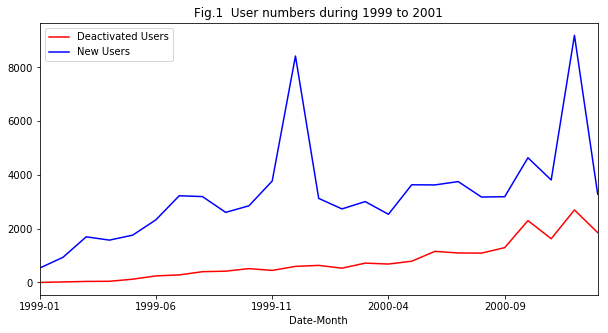

In [11]:
date_count.plot(color = ['r','b'],figsize = (10,5), title = 'Fig.1  User numbers during 1999 to 2001')

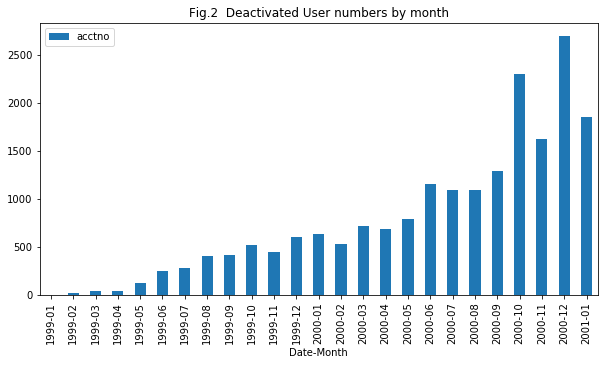

In [12]:
deact_gb.plot(kind = 'bar', figsize = (10,5), title = 'Fig.2  Deactivated User numbers by month')

### Step - 3:  
Segment the account base by account status – ‘deactivated’ and ‘still alive’ and by tenure: tenures are less than 30 days, between 31 and 60 days, between 61 days and one year, over a year. 

1.Test the general association between the tenure segments and ‘goodcredit’ ‘rateplan’ and ‘dealertype’

2.Test the general association between the account status and ‘goodcredit’ ‘rateplan’ and ‘dealertype’

In [13]:
# Get user status (using lambda funciton if is faster than def a if else function)
df['User Status'] = df['deactdt'].apply(lambda x : 'Still alive' if x == last_day else 'Deactivated' )

# cut fuction will not included the left side ( right incluced by default)
tenure_bins = pd.to_timedelta(['-1 days', '30 days', '60 days', '365 days', '732 days'])
tenure_labels = ['0 to 30 days','31 to 60 days', '61 days to 1 year','over 1 year']
df['Tenure Group'] = pd.cut(df['Tenure Days'], bins = tenure_bins, labels = tenure_labels)

df.head(3)

,acctno,actdt,deactdt,deactreason,goodcredit,rateplan,dealertype,Tenure Days,User Status,Tenure Group
0,1176913194483,1999-06-20,2001-01-21,Unknown,0,1,A1,581 days,Still alive,over 1 year
1,1176914599423,1999-10-04,1999-10-15,NEED,1,1,A1,11 days,Deactivated,0 to 30 days
2,1176951913656,2000-07-01,2001-01-21,Unknown,0,1,A1,204 days,Still alive,61 days to 1 year


In [14]:
# define a helper function for groupby question
def percent_of_all (series):
    '''return percent of total for each element in a series
    input: a numeric series
    output: string showing percentage '''
    # calculate the percentage 
    tmp = series / series.sum()
    # format the answer
    ans = tmp.apply(lambda x : '{:.2%}'.format(x))
    return ans

def df_group_per(dataframe, by):
    '''With given dataframe, returan a new dataframe groupby "by column" and show acct# account and percentage
    input: dateframe: pandas clean dataframe
    by: a list of string of column names which used to groupby
    
    output: a new dateframe with by and by_per columns only'''
    dataframe_gb = dataframe.groupby(by).count()[['acctno']]
    dataframe_gb['acctno_per'] = percent_of_all(dataframe_gb['acctno'])
    
    return dataframe_gb

In [15]:
user_status_pie = df_group_per(df, 'User Status')
user_status_pie

,acctno,acctno_per
User Status,,
Deactivated,19635,19.20%
Still alive,82620,80.80%


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002002368F0F0>], dtype=object)

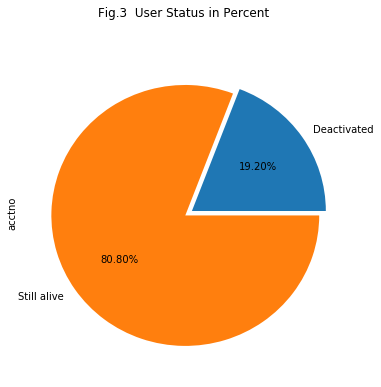

In [16]:
user_status_pie[['acctno']].plot(kind = 'pie', explode = (0.03, 0.03), autopct = '%.2f%%', figsize = (6,6), subplots = True,
                                legend = False, title = 'Fig.3  User Status in Percent')

In [17]:
tenure_group_pie =df_group_per(df, 'Tenure Group')
tenure_group_pie

,acctno,acctno_per
Tenure Group,,
0 to 30 days,9566,9.36%
31 to 60 days,8534,8.35%
61 days to 1 year,45404,44.40%
over 1 year,38751,37.90%


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002002366FCC0>], dtype=object)

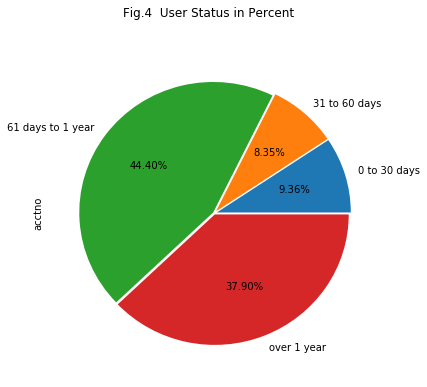

In [18]:
tenure_group_pie['acctno'].plot(kind = 'pie', explode = (0.02, 0.02, 0.01, 0.01), autopct = '%.2f%%', figsize = (6,6), 
                                subplots = True, legend = False, title = 'Fig.4  User Status in Percent')

In [19]:
# build helper functions to transfer data to contingency table
def get_unique_labels(oneDarray):
    '''Separate the unique row and column labels from given one D array, retuan by a dict 
    for example: 
    input: array([('a',1), ('a',2), ('a', 3), ('b',1), ('b',2), ('b',3)])
    output: {'row':['a','b'], 'column':[1,2,3]}'''
    
    temp_dict = {'row':[], 'column':[]}
    
    for item in oneDarray:
        if item[0] not in temp_dict['row']:
            temp_dict['row'].append(item[0])
        if item[1] not in temp_dict['column']:
            temp_dict['column'].append(item[1])
            
    return temp_dict

def to_contigency_table(dataframe, row, column):
    '''For given dataframe, return a new dataframe with new_index = row groupby value and new_column = column groupby value
    the values in the table will be counts based on account number
    row: row name in string ( one column of the dataframe)
    column: column name in string (one column of the dataframe)'''
    
    # get a new dataframe using groupby([row, column])
    grouped_df = dataframe.groupby([row, column]).count()[['acctno']]
     
    # get the new row and column values from dataframe
    labels_dict = get_unique_labels(grouped_df.index.values)
    
    # get the np-reshape size tuple like (4,2) here based on row and column number 
    row_column_tuple = (len(labels_dict['row']),len(labels_dict['column']))
    
    # reshape the np-array to be ready to build the new dataframe
    array_data = np.reshape(grouped_df.values, row_column_tuple)
    
    # build the target df
    target_df = pd.DataFrame(data = array_data, index = labels_dict['row'] ,columns= labels_dict['column'])
    
    return target_df

# to create a helper function to get merged output columns
def get_merged_df(df, row, column_list):
    '''return a merged dataframe for paired row and column contigency table '''
    # set the list of unmerged df
    unmerged_list = []
    # add the rest data into the df
    for i in range( len(column_list)): 
        unmerged_list.append(to_contigency_table(df, row, column_list[i]))
    
    # merge everything
    merged_df = pd.concat(unmerged_list, axis = 1)
        
    return merged_df

In [20]:
Tenure_Group_corr = get_merged_df(df, 'Tenure Group', ['dealertype', 'rateplan', 'goodcredit', 'User Status'])
Tenure_Group_corr

,A1,A2,B1,C1,1,2,3,0,1,Deactivated,Still alive
0 to 30 days,5417,913,1799,1437,4175,4474,917,2201,7365,3213,6353
31 to 60 days,4604,792,1639,1499,3763,3998,773,1893,6641,1136,7398
61 days to 1 year,24076,4188,10696,6444,32118,6724,6562,16512,28892,11427,33977
over 1 year,22035,5362,6536,4818,28138,4991,5622,10647,28104,3859,34892


In [21]:
User_Status_corr = get_merged_df(df,'User Status', ['dealertype', 'rateplan', 'goodcredit'])
User_Status_corr

,A1,A2,B1,C1,1,2,3,0,1
Deactivated,10631,2549,3879,2576,12469,3439,3727,8657,10978
Still alive,45501,8706,16791,11622,55725,16748,10147,22596,60024


In [22]:
# import stats to do Chi square test
from scipy import stats as ss

In [23]:
def get_CramerV_chi2p (contigency_dataframe):
    '''return a tuple (Cramer's V value, chi square p value) based on given contigency table dataframe'''
    
    # get the array values 
    df_array = contigency_dataframe.values
    
    # get chi squre value and p value
    chi2_p = ss.chi2_contingency(df_array)[:2]
    
    # calculate the Cramer's V value based on Wikipedia's formula
    sample_total = df_array.sum()
    shape_sub1 = min(df_array.shape) - 1
    cramer_v = np.sqrt(chi2_p[0]/(sample_total * shape_sub1 ))
    
    return (cramer_v, chi2_p[1])

# Printout the results of V value and P value
def printout_vp(dataframe, main_factor, other_factor):
    '''Based on given dataframe and main_factor and other_factor(s) to print out the v value and p value of chi squre test
    on each paired main factor and other factor
    
    dataframe: the dataframe has all data information
    main_factor: string, the main factor to be used, like User Status or Tenure Group
    other_factor(s): string or a list of string, the other factors to be used with main factor
    
    no output'''
    
    if type(other_factor) == str:
        chi2_str = to_contigency_table(dataframe, main_factor, other_factor)
        chi2_values = get_CramerV_chi2p(chi2_str)
        print('Between {} and {} factors:\n The P value of Chi Square test is: {};\n\
 The Cramer V value is: {}.\n-----------'.format(main_factor, other_factor, chi2_values[1], chi2_values[0]))
        
    elif type(other_factor) == list:
        for factor in other_factor:
            chi2_list = to_contigency_table(dataframe, main_factor, factor)
            chi2_values = get_CramerV_chi2p(chi2_list)
            print('Between {} and {} factors :\n The P value of Chi Square test is: {};\n\
 The Cramer V value is: {}.\n-----------\n'.format(main_factor, factor, chi2_values[1], chi2_values[0]))
    else:
        raise ValueError('Please enter the correct factor name(s)')

In [24]:
printout_vp(df,'Tenure Group', ['goodcredit', 'rateplan','dealertype','User Status'])

Between Tenure Group and goodcredit factors :
 The P value of Chi Square test is: 9.906813176926e-311;
 The Cramer V value is: 0.11844013402718538.
-----------

Between Tenure Group and rateplan factors :
 The P value of Chi Square test is: 0.0;
 The Cramer V value is: 0.2235623772227456.
-----------

Between Tenure Group and dealertype factors :
 The P value of Chi Square test is: 3.933922195864395e-242;
 The Cramer V value is: 0.06126216189494606.
-----------

Between Tenure Group and User Status factors :
 The P value of Chi Square test is: 0.0;
 The Cramer V value is: 0.21307224406352068.
-----------



In [25]:
printout_vp(df,'User Status', ['goodcredit','rateplan','dealertype'])

Between User Status and goodcredit factors :
 The P value of Chi Square test is: 0.0;
 The Cramer V value is: 0.14310639281767454.
-----------

Between User Status and rateplan factors :
 The P value of Chi Square test is: 5.4332819334025574e-136;
 The Cramer V value is: 0.07805004973927918.
-----------

Between User Status and dealertype factors :
 The P value of Chi Square test is: 7.726596205628729e-22;
 The Cramer V value is: 0.03149207059004648.
-----------

